<a href="https://colab.research.google.com/github/kgreed4/parkisons_exploration/blob/main/sts/movenet_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [39]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# MoveNet: Ultra fast and accurate pose detection model.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/movenet"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/movenet.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/movenet.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/movenet.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=movenet"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

**[MoveNet](https://t.co/QpfnVL0YYI?amp=1)** is an ultra fast and accurate model that detects 17 keypoints of a body. The model is offered on [TF Hub](https://tfhub.dev/s?q=movenet) with two variants, known as Lightning and Thunder. Lightning is intended for latency-critical applications, while Thunder is intended for applications that require high accuracy. Both models run faster than real time (30+ FPS) on most modern desktops, laptops, and phones, which proves crucial for live fitness, health, and wellness applications.


<img src="https://github.com/tensorflow/tfjs-models/raw/master/pose-detection/assets/combined_squat_dance.gif" alt="drawing"/>

*Images downloaded from Pexels (https://www.pexels.com/)

This Colab walks you through the details of how to load MoveNet, and run inference on the input image and video below.

Note: check out the [live demo](https://storage.googleapis.com/tfjs-models/demos/pose-detection/index.html?model=movenet) for how the model works!

# Human Pose Estimation with MoveNet

## Visualization libraries & Imports

In [1]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [3]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

## Load Model from TF hub

In [4]:
model_name = "movenet_lightning_f16.tflite" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

## Single Image Example

This session demonstrates the minimum working example of running the model on a **single image** to predict the 17 human keypoints.

### Load Input Image

In [5]:
!curl -o input_image.jpeg https://images.pexels.com/photos/4384679/pexels-photo-4384679.jpeg --silent

In [6]:
# Load the input image.
# my_im = '/content/IMG_1878.JPG'
# im = tf.io.read_file(my_im)
# im = tf.image.decode_jpeg(im)

image_path = 'input_image.jpeg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

In [7]:
# Print the height and width of image
print(image.shape)
# print(im.shape)

# # Resize im to (3989, 3286, 3)
# im = tf.image.resize(im, [3989, 3268])
# print(im.shape)

(3989, 3268, 3)


### Run Inference

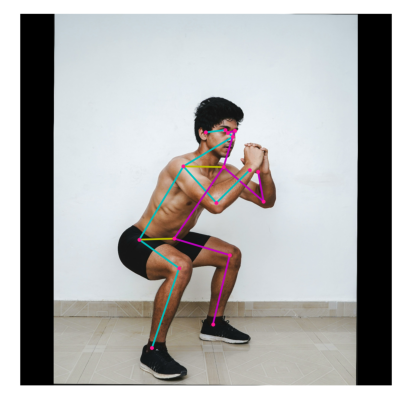

In [8]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

## Video (Image Sequence) Example

This section demonstrates how to apply intelligent cropping based on detections from the previous frame when the input is a sequence of frames. This allows the model to devote its attention and resources to the main subject, resulting in much better prediction quality without sacrificing the speed.


In [9]:
#@title Cropping Algorithm

# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  """Defines the default crop region.

  The function provides the initial crop region (pads the full image from both
  sides to make it a square image) when the algorithm cannot reliably determine
  the crop region from the previous frame.
  """
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints.

  This function checks whether the model is confident at predicting one of the
  shoulders/hips which is required to determine a good crop region.
  """
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location.

  The function returns the maximum distances from the two sets of keypoints:
  full 17 keypoints and 4 torso keypoints. The returned information will be
  used to determine the crop size. See determineCropRegion for more detail.
  """
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on.

  The algorithm uses the detected joints from the previous frame to estimate
  the square region that encloses the full body of the target person and
  centers at the midpoint of two hip joints. The crop size is determined by
  the distances between each joints and the center point.
  When the model is not confident with the four torso joint predictions, the
  function returns a default crop which is the full image padded to square.
  """
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

def run_inference(movenet, image, crop_region, crop_size):
  """Runs model inference on the cropped region.

  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width
  return keypoints_with_scores

### Load Input Image Sequence

In [45]:
!wget -q -O dance.gif https://github.com/tensorflow/tfjs-models/raw/master/pose-detection/assets/dance_input.gif

In [10]:
!pip install tensorflow_io
import tensorflow_io as tfio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 12.0 MB/s eta 0:00:00


In [11]:
# Load the input image.
# image_path = '/content/dance.gif'
# image = tf.io.read_file(image_path)
# image = tf.image.decode_gif(image)
import numpy as np
import tensorflow as tf

video_path = '/content/IMG_8295.MOV'
video = tf.io.read_file(video_path)
video = tfio.experimental.ffmpeg.decode_video(video)

In [12]:
image = video

### Run Inference with Cropping Algorithm

In [13]:
# Load the input image.
num_frames, image_height, image_width, _ = image.shape
crop_region = init_crop_region(image_height, image_width)

output_images = []
bar = display(progress(0, num_frames-1), display_id=True)
for frame_idx in range(num_frames):
  keypoints_with_scores = run_inference(
      movenet, image[frame_idx, :, :, :], crop_region,
      crop_size=[input_size, input_size])
  output_images.append(draw_prediction_on_image(
      image[frame_idx, :, :, :].numpy().astype(np.int32),
      keypoints_with_scores, crop_region=None,
      close_figure=True, output_image_height=300))
  crop_region = determine_crop_region(
      keypoints_with_scores, image_height, image_width)
  bar.update(progress(frame_idx, num_frames-1))

# Prepare gif visualization.
# output = np.stack(output_images, axis=0)
# to_gif(output, duration=100)

In [14]:
# Extract the keypoints so they can be written into a csv
KEYPOINT = {
    0: 'nose',
    1: 'left_eye',
    2: 'right_eye',
    3: 'left_ear',
    4: 'right_ear',
    5: 'left_shoulder',
    6: 'right_shoulder',
    7: 'left_elbow',
    8: 'right_elbow',
    9: 'left_wrist',
    10: 'right_wrist',
    11: 'left_hip',
    12: 'right_hip',
    13: 'left_knee',
    14: 'right_knee',
    15: 'left_ankle',
    16: 'right_ankle'
}
print(keypoints_with_scores[0, 0])

[[0.49325916 0.05806314 0.35326722]
 [0.40435374 0.03654843 0.39102164]
 [0.53655434 0.03355795 0.41795212]
 [0.27899796 0.06020461 0.56833005]
 [0.59126145 0.04321534 0.36971176]
 [0.26651037 0.23008914 0.34745154]
 [0.7629119  0.2223759  0.3439662 ]
 [0.30544773 0.49163717 0.5314293 ]
 [0.9744227  0.3344747  0.25251874]
 [0.29342923 0.7112216  0.61166453]
 [0.9457265  0.33731994 0.16110706]
 [0.434478   0.7014949  0.3276603 ]
 [0.65921265 0.7162401  0.3733899 ]
 [0.46242988 0.9771747  0.3515047 ]
 [0.95708317 0.49379724 0.13204911]
 [0.3003096  0.7444631  0.17229833]
 [0.80759346 0.4361195  0.06327864]]


In [15]:
keypoints_with_scores[0, 0]
for i in range(17):
  print(KEYPOINT[i], keypoints_with_scores[0, 0, i, 0], keypoints_with_scores[0, 0, i, 1])

nose 0.49325916 0.058063142
left_eye 0.40435374 0.03654843
right_eye 0.53655434 0.03355795
left_ear 0.27899796 0.060204607
right_ear 0.59126145 0.043215342
left_shoulder 0.26651037 0.23008914
right_shoulder 0.7629119 0.2223759
left_elbow 0.30544773 0.49163717
right_elbow 0.9744227 0.3344747
left_wrist 0.29342923 0.7112216
right_wrist 0.9457265 0.33731994
left_hip 0.434478 0.7014949
right_hip 0.65921265 0.7162401
left_knee 0.46242988 0.9771747
right_knee 0.95708317 0.49379724
left_ankle 0.3003096 0.7444631
right_ankle 0.80759346 0.4361195


In [16]:
import subprocess

video_path = '/content/IMG_8295.MOV'

# Run ffprobe to get video metadata
ffprobe_command = [
    'ffprobe', '-v', 'error', '-select_streams', 'v:0', '-show_entries',
    'stream=avg_frame_rate', '-of', 'default=noprint_wrappers=1:nokey=1',
    video_path
]
output = subprocess.check_output(ffprobe_command).decode('utf-8').strip()

# Parse the output to get the frame rate
numerator, denominator = map(int, output.split('/'))
frame_rate = numerator / denominator

print("Frame rate:", frame_rate)


Frame rate: 30.0


In [17]:
from datetime import timedelta

# Assuming you have the frame rate of the video stored in a variable `frame_rate`.
# Calculate the time interval between frames.
time_interval = timedelta(seconds=1 / frame_rate)

# Initialize an empty list to store the timestamps for each frame.
frame_times = []

# Loop through each frame.
for frame_idx in range(num_frames):
    # Calculate the timestamp for the current frame.
    frame_time = time_interval * frame_idx
    frame_times.append(frame_time)

print(frame_times)

[datetime.timedelta(0), datetime.timedelta(microseconds=33333), datetime.timedelta(microseconds=66666), datetime.timedelta(microseconds=99999), datetime.timedelta(microseconds=133332), datetime.timedelta(microseconds=166665), datetime.timedelta(microseconds=199998), datetime.timedelta(microseconds=233331), datetime.timedelta(microseconds=266664), datetime.timedelta(microseconds=299997), datetime.timedelta(microseconds=333330), datetime.timedelta(microseconds=366663), datetime.timedelta(microseconds=399996), datetime.timedelta(microseconds=433329), datetime.timedelta(microseconds=466662), datetime.timedelta(microseconds=499995), datetime.timedelta(microseconds=533328), datetime.timedelta(microseconds=566661), datetime.timedelta(microseconds=599994), datetime.timedelta(microseconds=633327), datetime.timedelta(microseconds=666660), datetime.timedelta(microseconds=699993), datetime.timedelta(microseconds=733326), datetime.timedelta(microseconds=766659), datetime.timedelta(microseconds=7999

In [18]:
KEYPOINT_DICT.keys()

dict_keys(['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle'])

In [19]:
label_list = []
label_list = ['frame #', 'time']
for i in KEYPOINT_DICT.keys():
  label_list.append(i+'_x')
  label_list.append(i+'_y')

In [20]:
import pandas as pd
# Create df to store output for each point at each frame
df = pd.DataFrame(columns=label_list)

In [21]:
df

,frame #,time,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y


In [22]:
keypoints = []
for i in range(17):
  keypoints.append(keypoints_with_scores[0, 0, i, 0])
  keypoints.append(keypoints_with_scores[0, 0, i, 1])

# Add to the df
df.loc[frame_idx] = [frame_idx, frame_time] + keypoints

In [23]:
df

,frame #,time,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
114,114,0 days 00:00:03.799962,0.493259,0.058063,0.404354,0.036548,0.536554,0.033558,0.278998,0.060205,...,0.659213,0.71624,0.46243,0.977175,0.957083,0.493797,0.30031,0.744463,0.807593,0.436119


In [24]:
# Load the input image.
num_frames, image_height, image_width, _ = image.shape
crop_region = init_crop_region(image_height, image_width)

output_images = []
bar = display(progress(0, num_frames-1), display_id=True)

# Loop through the frames
for frame_idx in range(num_frames):

  # Get keypoints
  keypoints_with_scores = run_inference(
      movenet, image[frame_idx, :, :, :], crop_region,
      crop_size=[input_size, input_size])

  # Calculate the timestamp for the current frame.
  frame_time = time_interval * frame_idx

  # Extract keypoints
  keypoints = []
  for i in range(17):
    keypoints.append(keypoints_with_scores[0, 0, i, 0])
    keypoints.append(keypoints_with_scores[0, 0, i, 1])

  df.loc[frame_idx] = [frame_idx, frame_time] + keypoints

  # Crop the frame to the region of interest.
  crop_region = determine_crop_region(
      keypoints_with_scores, image_height, image_width)
  bar.update(progress(frame_idx, num_frames-1))

In [25]:
df

,frame #,time,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
114,114,0 days 00:00:03.799962,0.493259,0.058063,0.404354,0.036548,0.536554,0.033558,0.278998,0.060205,...,0.659213,0.716240,0.462430,0.977175,0.957083,0.493797,0.300310,0.744463,0.807593,0.436119
0,0,0 days 00:00:00,0.466861,0.507406,0.396730,0.488343,0.514201,0.475763,0.287454,0.487710,...,0.751784,0.969775,0.720760,0.946792,0.846099,0.736565,0.771264,0.925216,0.835929,0.777834
1,1,0 days 00:00:00.033333,0.470563,0.508447,0.402035,0.488919,0.519396,0.479238,0.289095,0.490584,...,0.709720,0.973117,0.730839,0.932439,0.848137,0.735255,0.665601,0.942927,0.815488,0.788908
2,2,0 days 00:00:00.066666,0.498676,0.502981,0.421300,0.474876,0.533752,0.475847,0.317374,0.483207,...,0.708491,0.953538,0.726499,0.935251,0.853598,0.731645,0.601032,0.940160,0.787121,0.858533
3,3,0 days 00:00:00.099999,0.504021,0.504129,0.424364,0.487251,0.540952,0.476440,0.316540,0.488412,...,0.710207,0.970653,0.692312,0.913048,0.856063,0.735329,0.595443,0.919663,0.735586,0.859370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,109,0 days 00:00:03.633297,0.495052,0.056930,0.410225,0.038086,0.534907,0.032947,0.290138,0.061434,...,0.629910,0.681924,0.456004,0.974750,0.475870,0.976429,0.312751,0.751252,0.308827,0.727955
110,110,0 days 00:00:03.666630,0.461600,0.045990,0.388869,0.032698,0.499198,0.025903,0.276801,0.058766,...,0.661063,0.698439,0.452135,0.978717,0.943951,0.486307,0.310290,0.744972,0.723530,0.453631
111,111,0 days 00:00:03.699963,0.464708,0.042174,0.389621,0.027970,0.499619,0.022131,0.278822,0.056454,...,0.666921,0.694525,0.456997,0.978991,0.933963,0.490089,0.302795,0.739973,0.811067,0.437224
112,112,0 days 00:00:03.733296,0.493574,0.061064,0.424663,0.040144,0.535362,0.035125,0.284885,0.056988,...,0.629070,0.706565,0.453358,0.975799,0.930540,0.266855,0.302714,0.737232,0.706389,0.572319


In [30]:
# Write df to a csv
df.to_csv('test_output.csv', index=False)

# Processing Data Output

In [26]:
import pandas as pd

In [35]:
# Read from test csv
df = pd.read_csv('test_output.csv')

# Strip the time input so it is just 00:00:03.799962
# df['time'] = df['time'].apply(lambda x: x.split('s')[1])
# df['time'] = pd.to_datetime(df['time'])

In [27]:
df.head()

,frame #,time,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
114,114,0 days 00:00:03.799962,0.493259,0.058063,0.404354,0.036548,0.536554,0.033558,0.278998,0.060205,...,0.659213,0.716240,0.462430,0.977175,0.957083,0.493797,0.300310,0.744463,0.807593,0.436119
0,0,0 days 00:00:00,0.466861,0.507406,0.396730,0.488343,0.514201,0.475763,0.287454,0.487710,...,0.751784,0.969775,0.720760,0.946792,0.846099,0.736565,0.771264,0.925216,0.835929,0.777834
1,1,0 days 00:00:00.033333,0.470563,0.508447,0.402035,0.488919,0.519396,0.479238,0.289095,0.490584,...,0.709720,0.973117,0.730839,0.932439,0.848137,0.735255,0.665601,0.942927,0.815488,0.788908
2,2,0 days 00:00:00.066666,0.498676,0.502981,0.421300,0.474876,0.533752,0.475847,0.317374,0.483207,...,0.708491,0.953538,0.726499,0.935251,0.853598,0.731645,0.601032,0.940160,0.787121,0.858533
3,3,0 days 00:00:00.099999,0.504021,0.504129,0.424364,0.487251,0.540952,0.476440,0.316540,0.488412,...,0.710207,0.970653,0.692312,0.913048,0.856063,0.735329,0.595443,0.919663,0.735586,0.859370


In [28]:
# Create the csv output that is needed to train the model
# Transition ID,Participant ID number,PD_or_C,sts_whole_episode_duration,sts_final_attempt_duration,On_or_Off_medication,DBS_state,Clinical_assessment,STS_additional_features,MDS-UPDRS_score_3.9 _arising_from_chair
output_df = pd.DataFrame(columns=['sts_whole_episode_duration','sts_final_attempt_duration','On_or_Off_medication','DBS_state','STS_additional_features','MDS-UPDRS_score_3.9 _arising_from_chair'])

# want to drop: transition, part, clincial assessment

# Get input from the user
on_off_medication = input("On or Off medication: ") #either On medication, Off medication
dbs_state = input("DBS state: ") # If healthy control participant: always "Control". If participant with Parkinson's disease: either "On DBS" (deep brain stimulator switched on or within 1 hour of it being switched off), "Off DBS" (1 hour or longer after deep brain stimulator switched off until it is switched back on again) or "-" (no deep brain stimulator in situ).

# A note to describe extra features of the STS episode: "slow" (subjective rating), "Uses arms of chair" (which denotes using nearby flat surface to lever up from chair to standing),
# "Moves forward in chair" (prior to standing up), ">1 attempt" (person tries more than once to get up before being successful), "Carrying something" (in hands),
# "unable to arise without help".
# sts_additional_features = input("STS additional features: ")

# MDS-UPDRS_score_3.9 _arising_from_chair - range of normal standing or not
# 0 = normal, 4 = unable to stand without help


# Set attributes inputted to output_df
output_df.loc[0, 'On_or_Off_medication'] = on_off_medication
output_df.loc[0, 'DBS_state'] = dbs_state
# output_df.loc[0, 'STS_additional_features'] = sts_additional_features

On or Off medication: Off medication
DBS state: -


In [29]:
from datetime import timedelta

# Functions to create output for sts prediction model
'''
This function ges the input from the user and sets the attributes of the output_df.
'''
def get_input(output_df):
  # Get input from the user
  on_off_medication = input("On or Off medication: ") #either On medication, Off medication
  dbs_state = input("DBS state: ") # If healthy control participant: always "Control". If participant with Parkinson's disease: either "On DBS" (deep brain stimulator switched on or within 1 hour of it being switched off), "Off DBS" (1 hour or longer after deep brain stimulator switched off until it is switched back on again) or "-" (no deep brain stimulator in situ).

  # Set attributes inputted to output_df
  output_df.loc[0, 'On_or_Off_medication'] = on_off_medication
  output_df.loc[0, 'DBS_state'] = dbs_state
  return output_df

'''
This function calculates the sts_whole_episode_duration.
'''
def calculate_sts_whole_episode_duration(df, output_df):
  # Get frame 3 time
  start_time = df.loc[df['frame #'] == 3, 'time'].iloc[0]

  # Find the max frame
  max_frame = df['frame #'].max()
  end_time = df.loc[df['frame #'] == max_frame-3, 'time'].iloc[0]

  sts_whole_episode_duration = end_time - start_time

  # Save in first entry of output_df
  output_df.loc[0, 'sts_whole_episode_duration'] = sts_whole_episode_duration.total_seconds()

  return output_df


def calculate_sts_final_attempt_duration(df, output_df):
  # Duration in seconds of "final attempt duration" label in milliseconds, comprising their impression of the duration between the lowest point of the head (start)
  # and when the person was fully upright/the maximum vertical position of the vertex of the head (end).

  # Create a head column that is the average y values of nose_y, left_eye_y, right_eye_y, left_ear_y, right_ear_y
  df['head'] = (df['nose_y'] + df['left_eye_y'] + df['right_eye_y'] + df['left_ear_y'] + df['right_ear_y']) / 5

  # Get min and max values and their rows from head column
  # REMEMBER: Pose estimation y-axis starts at top left corner and moves down (reverse)
  min_head = df['head'].min()
  max_head = df['head'].max()

  # Get highest head point
  highest_head = df[df['head'] == min_head]

  # Get lowest head point
  lowest_head = df[df['head'] == max_head]

  # Get time entry at highest_head and lowest_head
  highest_head_time = highest_head['time'].iloc[0]
  lowest_head_time = lowest_head['time'].iloc[0]
  print('Highest head time: ', highest_head_time, 'Lowest head time: ', lowest_head_time)

  # Calculate final attempt duration
  final_attempt_duration = highest_head_time.total_seconds() - lowest_head_time.total_seconds()
  print('Total duration: ', final_attempt_duration)

  # Save in second entry of output_df
  output_df.loc[0, 'sts_final_attempt_duration'] = final_attempt_duration

  return output_df

def calculate_MDS_UPDRS_score_3_9_and_STS_additional_features(df, output_df):
  mds_score = 0
  STS_additional_features = []

  # Compute the differene between min and max values of left_shoulder_x, right_shoudler_x, right_elbow_x, left_elbow_x, left_hip_x, right_hip_x from df
  left_shoulder_x_diff = df['left_shoulder_x'].max() - df['left_shoulder_x'].min()
  right_shoulder_x_diff = df['right_shoulder_x'].max() - df['right_shoulder_x'].min()
  left_elbow_x_diff = df['left_elbow_x'].max() - df['left_elbow_x'].min()
  right_elbow_x_diff = df['right_elbow_x'].max() - df['right_elbow_x'].min()
  left_hip_x_diff = df['left_hip_x'].max() - df['left_hip_x'].min()
  right_hip_x_diff = df['right_hip_x'].max() - df['right_hip_x'].min()

  # Compare differences to threshold value to determine swaying
  threshold = 0.25
  if left_shoulder_x_diff > threshold or right_shoulder_x_diff > threshold or left_elbow_x_diff > threshold or right_elbow_x_diff > threshold or left_hip_x_diff > threshold or right_hip_x_diff > threshold:
      mds_score = 2
      STS_additional_features.append("Uses arms of chair")
  else:
      print("No sway detected.")

  # If whole duration > ~5.5 seconds then MDS score = 3
  if output_df['sts_whole_episode_duration'] > 5.5:
    mds_score = 3

  # If final duration is greater than 2.1 seconds, then STS additioanl features include "Slow"
  if output_df.loc['sts_final_attempt_duration', 0] > 2.1:
      STS_additional_features.append("Slow")

  # Set mds_score and STS additional features in output_df
  output_df.loc[0, 'MDS-UPDRS_score_3.9 _arising_from_chair'] = mds_score
  output_df.loc[0, 'STS_additional_features'] = ','.join(STS_additional_features)

  return output_df

In [30]:
from datetime import timedelta
# Calculate sts_whole_episode_duration
# Assume frames 3 to end-3 is the whole duration

# Get frame 3 time
start_time = df.loc[df['frame #'] == 3, 'time'].iloc[0]
print(start_time, type(start_time))

max_frame = df['frame #'].max()
end_time = df.loc[df['frame #'] == max_frame-3, 'time'].iloc[0]
print(end_time)

sts_whole_episode_duration = end_time - start_time
print(sts_whole_episode_duration.total_seconds())

# Save in first entry of output_df
output_df.loc[0, 'sts_whole_episode_duration'] = sts_whole_episode_duration.total_seconds()

0 days 00:00:00.099999 <class 'pandas._libs.tslibs.timedeltas.Timedelta'>
0 days 00:00:03.699963
3.599964


In [31]:
# nose 0.49325916 0.058063142
# left_eye 0.40435374 0.03654843
# right_eye 0.53655434 0.03355795
# left_ear 0.27899796 0.060204607
# right_ear 0.59126145 0.043215342

# Duration in seconds of "final attempt duration" label in milliseconds, comprising their impression of the duration between the lowest point of the head (start)
# and when the person was fully upright/the maximum vertical position of the vertex of the head (end).

# Create a head column that is the average y values of nose_y, left_eye_y, right_eye_y, left_ear_y, right_ear_y
df['head'] = (df['nose_y'] + df['left_eye_y'] + df['right_eye_y'] + df['left_ear_y'] + df['right_ear_y']) / 5

# Get min and max values and their rows from head column
# REMEMBER: Pose estimation y-axis starts at top left corner and moves down (reverse)
min_head = df['head'].min()
max_head = df['head'].max()

# Get highest head point
highest_head = df[df['head'] == min_head]

# Get lowest head point
lowest_head = df[df['head'] == max_head]

# Get time entry at highest_head and lowest_head
highest_head_time = highest_head['time'].iloc[0]
lowest_head_time = lowest_head['time'].iloc[0]
print('Highest head time: ', highest_head_time, 'Lowest head time: ', lowest_head_time)

# Calculate final attempt duration
final_attempt_duration = highest_head_time.total_seconds() - lowest_head_time.total_seconds()
print('Total duration: ', final_attempt_duration)

# Save in second entry of output_df
output_df.loc[0, 'sts_final_attempt_duration'] = final_attempt_duration

Highest head time:  0 days 00:00:03.199968 Lowest head time:  0 days 00:00:00.033333
Total duration:  3.1666350000000003


In [32]:
output_df.head()

,sts_whole_episode_duration,sts_final_attempt_duration,On_or_Off_medication,DBS_state,STS_additional_features,MDS-UPDRS_score_3.9 _arising_from_chair
0,3.599964,3.166635,Off medication,-,NaN,NaN


## Solving helping chair problem

In [35]:
# Filter sts_df for if the MDS-UPDRS_score_3.9 _arising_from_chair >= 3
sts_df = pd.read_csv('/content/SitToStand_human_labels.csv')
filtered_sts = sts_df[sts_df['MDS-UPDRS_score_3.9 _arising_from_chair'] >= 3]

print('len of >=3: ', len(filtered_sts))

# Print all the sts_whole_episode_duration
print(filtered_sts['sts_whole_episode_duration'])
avg_filtered_sts = filtered_sts['sts_whole_episode_duration'].mean()
print('avg of >=3: ', avg_filtered_sts)

# Print avg without filter
avg_sts = sts_df['sts_whole_episode_duration'].mean()
print('avg: ', avg_sts)

# Roughly could do if whole duration > ~5.5 seconds then 3/4 score
if output_df.loc[0, 'sts_whole_episode_duration'] > 5.5:
  output_df.loc[0, 'MDS-UPDRS_score_3.9 _arising_from_chair'] = 3

len of >=3:  9
87      4.622999
135    10.428000
136     6.116000
137    13.340999
169     2.663000
171     3.357999
175     9.001999
190     2.468000
317     6.028999
Name: sts_whole_episode_duration, dtype: float64
avg of >=3:  6.4475549999999995
avg:  2.259870558312655


In [36]:
# Detect sideways motion while standing (leaning, etc.)
# left_shoulder 0.26651037 0.23008914
# right_shoulder 0.7629119 0.2223759
# left_elbow 0.30544773 0.49163717
# right_elbow 0.9744227 0.3344747
# left_hip 0.434478 0.7014949
# right_hip 0.65921265 0.7162401

# Get min, max, and average left_shoulder_x, right_shoudler_x, right_elbow_x, left_elbow_x, left_hip_x, right_hip_x from df
min_left_shoulder_x = df['left_shoulder_x'].min()
max_left_shoulder_x = df['left_shoulder_x'].max()
avg_left_shoulder_x = df['left_shoulder_x'].mean()

print(f"min_left_shoulder_x: {min_left_shoulder_x}")
print(f"max_left_shoulder_x: {max_left_shoulder_x}")
print(f"avg_left_shoulder_x: {avg_left_shoulder_x}")

min_right_shoulder_x = df['right_shoulder_x'].min()
max_right_shoulder_x = df['right_shoulder_x'].max()
avg_right_shoulder_x = df['right_shoulder_x'].mean()

print(f"min_right_shoulder_x: {min_right_shoulder_x}")
print(f"max_right_shoulder_x: {max_right_shoulder_x}")
print(f"avg_right_shoulder_x: {avg_right_shoulder_x}")

min_right_elbow_x = df['right_elbow_x'].min()
max_right_elbow_x = df['right_elbow_x'].max()
avg_right_elbow_x = df['right_elbow_x'].mean()

print(f"min_right_elbow_x: {min_right_elbow_x}")
print(f"max_right_elbow_x: {max_right_elbow_x}")
print(f"avg_right_elbow_x: {avg_right_elbow_x}")

min_left_elbow_x = df['left_elbow_x'].min()
max_left_elbow_x = df['left_elbow_x'].max()
avg_left_elbow_x = df['left_elbow_x'].mean()

print(f"min_left_elbow_x: {min_left_elbow_x}")
print(f"max_left_elbow_x: {max_left_elbow_x}")
print(f"avg_left_elbow_x: {avg_left_elbow_x}")

min_left_hip_x = df['left_hip_x'].min()
max_left_hip_x = df['left_hip_x'].max()
avg_left_hip_x = df['left_hip_x'].mean()

print(f"min_left_hip_x: {min_left_hip_x}")
print(f"max_left_hip_x: {max_left_hip_x}")
print(f"avg_left_hip_x: {avg_left_hip_x}")

min_right_hip_x = df['right_hip_x'].min()
max_right_hip_x = df['right_hip_x'].max()
avg_right_hip_x = df['right_hip_x'].mean()

print(f"min_right_hip_x: {min_right_hip_x}")
print(f"max_right_hip_x: {max_right_hip_x}")
print(f"avg_right_hip_x: {avg_right_hip_x}")

# Rough threshold ~0.25 / .3 difference between max and min values?

min_left_shoulder_x: 0.2585059404373169
max_left_shoulder_x: 0.4265916645526886
avg_left_shoulder_x: 0.33719879388809204
min_right_shoulder_x: 0.6763109564781189
max_right_shoulder_x: 0.9050685167312622
avg_right_shoulder_x: 0.7874081134796143
min_right_elbow_x: 0.8313137888908386
max_right_elbow_x: 1.0004286766052246
avg_right_elbow_x: 0.9195629358291626
min_left_elbow_x: 0.2583397626876831
max_left_elbow_x: 0.3869754374027252
avg_left_elbow_x: 0.326977401971817
min_left_hip_x: 0.40957534313201904
max_left_hip_x: 0.6148000359535217
avg_left_hip_x: 0.4923502504825592
min_right_hip_x: 0.6164688467979431
max_right_hip_x: 0.8308296203613281
avg_right_hip_x: 0.7472293376922607


In [37]:
# Get min, max, and average left_shoulder_x, right_shoudler_x, right_elbow_x, left_elbow_x, left_hip_x, right_hip_x from df
min_left_shoulder_x = df['left_shoulder_x'].min()
max_left_shoulder_x = df['left_shoulder_x'].max()
avg_left_shoulder_x = df['left_shoulder_x'].mean()

min_right_shoulder_x = df['right_shoulder_x'].min()
max_right_shoulder_x = df['right_shoulder_x'].max()
avg_right_shoulder_x = df['right_shoulder_x'].mean()

min_right_elbow_x = df['right_elbow_x'].min()
max_right_elbow_x = df['right_elbow_x'].max()
avg_right_elbow_x = df['right_elbow_x'].mean()

min_left_elbow_x = df['left_elbow_x'].min()
max_left_elbow_x = df['left_elbow_x'].max()
avg_left_elbow_x = df['left_elbow_x'].mean()

min_left_hip_x = df['left_hip_x'].min()
max_left_hip_x = df['left_hip_x'].max()
avg_left_hip_x = df['left_hip_x'].mean()

min_right_hip_x = df['right_hip_x'].min()
max_right_hip_x = df['right_hip_x'].max()
avg_right_hip_x = df['right_hip_x'].mean()

# Compute the differene between min and max values of left_shoulder_x, right_shoudler_x, right_elbow_x, left_elbow_x, left_hip_x, right_hip_x from df
left_shoulder_x_diff = df['left_shoulder_x'].max() - df['left_shoulder_x'].min()
right_shoulder_x_diff = df['right_shoulder_x'].max() - df['right_shoulder_x'].min()
left_elbow_x_diff = df['left_elbow_x'].max() - df['left_elbow_x'].min()
right_elbow_x_diff = df['right_elbow_x'].max() - df['right_elbow_x'].min()
left_hip_x_diff = df['left_hip_x'].max() - df['left_hip_x'].min()
right_hip_x_diff = df['right_hip_x'].max() - df['right_hip_x'].min()

# Compare differences to threshold value to determine swaying
threshold = 0.25
if left_shoulder_x_diff > threshold or right_shoulder_x_diff > threshold or left_elbow_x_diff > threshold or right_elbow_x_diff > threshold or left_hip_x_diff > threshold or right_hip_x_diff > threshold:
    print("Swaying detected!")
    print(f"Uses arms of chair")
    output_df.loc[0, 'MDS-UPDRS_score_3.9 _arising_from_chair'] = 2
    output_df.loc[0, 'STS_additional_features'] = "Uses arms of chair"
else:
    print("No sway detected.")

No sway detected.


In [44]:
type(output_df.loc[0, 'sts_final_attempt_duration'])

float

In [45]:
# Determine attribute of slow for STS_additional_features
# Filter sts_df for STS_additional_features where the word slow appears
slow_df = sts_df[sts_df['STS_additional_features'].str.contains('Slow', na=False)]
print('len of slow: ', len(slow_df))

# Find the min, max, avg sts_final_attempt_duration for those in slow_df
min_slow = slow_df['sts_final_attempt_duration'].min()
max_slow = slow_df['sts_final_attempt_duration'].max()
avg_slow = slow_df['sts_final_attempt_duration'].mean()
median_slow = slow_df['sts_final_attempt_duration'].median()
mode_slow = slow_df['sts_final_attempt_duration'].mode()

print(f"min_slow: {min_slow}")
print(f"max_slow: {max_slow}")
print(f"avg_slow: {avg_slow}")
print(f"median_slow: {median_slow}")
print(f"mode_slow: {mode_slow}")

print(output_df.loc[0, 'sts_final_attempt_duration'])

# If final duration is greater than 2.1, then slow
if output_df.loc[0, 'sts_final_attempt_duration'] > 2.1:
    output_df.loc[0, 'STS_additional_features'] = "Slow"

len of slow:  104
min_slow: 0.799999
max_slow: 8.507999
avg_slow: 2.144663057692308
median_slow: 1.7739995
mode_slow: 0    1.428
Name: sts_final_attempt_duration, dtype: float64
3.1666350000000003


In [47]:
output_df.loc[0, 'MDS-UPDRS_score_3.9 _arising_from_chair'] = 0

In [57]:
output_df

,sts_whole_episode_duration,sts_final_attempt_duration,On_or_Off_medication,DBS_state,STS_additional_features,MDS-UPDRS_score_3.9 _arising_from_chair
0,3.599964,3.166635,0,0,0,0


## Test by passing sample video into model

In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Create a neural network based on the df, where y = PD_or_C column

def organize_data(df):
# Encode categorical variables
  label_encoder = LabelEncoder()
  df['On_or_Off_medication'] = label_encoder.fit_transform(df['On_or_Off_medication'])
  df['STS_additional_features'] = label_encoder.fit_transform(df['STS_additional_features'])
  df['DBS_state'] = label_encoder.fit_transform(df['DBS_state'])

  # Standardize features
  scaler = StandardScaler()
  X = scaler.fit_transform(df)
  return X

def load_model():
  # Load the model
  model = tf.keras.models.load_model('sts_model.h5')
  return model

def evaluate_video(df):
  # Pass df into the model
  model = load_model()
  X = organize_data(df)
  y_pred = model.predict(X)
  # 1: Control, 0: PD
  y_pred = (y_pred > 0.5).astype(int)
  return y_pred[0][0]

In [66]:
prediction = evaluate_video(output_df)
print(prediction)

1/1 [==============================] - 0s 84ms/step
1


## Work Around of TF.io

In [48]:
import tensorflow as tf
import numpy as np
import subprocess

def extract_frames(video_path, output_folder, fps=30):
    """
    Extract frames from a video using FFmpeg at the specified frame rate.

    Args:
    video_path (str): Path to the input video file.
    output_folder (str): Folder to save the extracted frames.
    fps (int): Number of frames per second to extract.
    """
    command = [
        'ffmpeg',
        '-i', video_path,
        '-vf', f'fps={fps}',
        f'{output_folder}/frame_%04d.png'
    ]
    subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def load_and_stack_images(image_folder):
    """
    Load images from a folder, preprocess them, and stack into a single tensor.

    Args:
    image_folder (str): Path to the folder containing the image frames.
    """
    image_paths = tf.io.gfile.glob(f"{image_folder}/*.png")
    images = [load_and_preprocess_image(path) for path in image_paths]
    tensor = tf.stack(images)  # Stack images along a new axis
    return tensor

video_path = '../test-data/sts-test.MOV'
output_folder = '.'

# Extract frames using the extract_frames function as before
extract_frames(video_path, output_folder)

# Load images and stack into a single tensor
video_tensor = load_and_stack_images(output_folder)

# Check the shape and use the tensor
print(video_tensor.shape)  # Should print (num_frames, 224, 224, 3)


(115, 1920, 1080, 3)


In [49]:
type(video_tensor)

tensorflow.python.framework.ops.EagerTensor

In [50]:
import cv2
import tensorflow as tf

def process_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
        frame = cv2.resize(frame, (224, 224))  # Resize the frame
        frame_tensor = tf.convert_to_tensor(frame, dtype=tf.float32) / 255.0
        frames.append(frame_tensor)

    cap.release()
    return tf.stack(frames)  # Stack into one tensor

# Example usage
video_path = '../test-data/sts-test.MOV'
video_tensor = process_video_frames(video_path)
print("Video Tensor Shape:", video_tensor.shape)  # Outputs (num_frames, 224, 224, 3)


Video Tensor Shape: (115, 224, 224, 3)


In [51]:
type(video_tensor)

tensorflow.python.framework.ops.EagerTensor